In [57]:
# =============================
# Imports gerais
# =============================
import os
import math
import warnings
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error
)
from sklearn.model_selection import (
    KFold,
    RepeatedKFold
)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, randint

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge

from joblib import Parallel, delayed

warnings.filterwarnings("ignore")
np.random.seed(42)


In [58]:
# Funções utilitárias

def safe_log(y):
    return np.sign(y) * np.log1p(np.abs(y))

def inverse_safe_log(y_log):
    return np.sign(y_log) * (np.expm1(np.abs(y_log)))


In [59]:
# Carregar dataset

print("Loading dataset...")

shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'

try:
    df = gpd.read_file(shp_path)
    print("Dataset loaded")
except Exception as e:
    raise RuntimeError(f"Error loading dataset: {e}")


Loading dataset...
Dataset loaded


In [60]:
# Pré-processamento

columns_removed = ['ros_p_lg1']
df.drop(columns=columns_removed, inplace=True)

# Remover colunas com mais de 15% de NaNs
threshold = 0.15  # 15%
cols_to_drop = df.columns[df.isna().mean() > threshold]
df.drop(columns=cols_to_drop, inplace=True)

print(f"Removed columns with >15% NaNs: {list(cols_to_drop)}")

# Remover NaN no target
n_before = len(df)
df = df.dropna(subset=['ros_p'])
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'")

# Converter categóricas
cat_cols = ["fuel_model", "landform", "land_use", "Haines_av"]
for col in cat_cols:
    if col in df.columns:  # só converte se a coluna ainda existir
        df[col] = df[col].astype(str).astype("category")

print("Columns disponíveis:")
for col in df.columns:
    print(col)

Removed columns with >15% NaNs: ['gT_s_9_av', 'CBH_m_av', 'Cin_av', 'LFC_hPa_av', 'EL_m_av']
Removed 0 rows with NaN in 'ros_p'
Columns disponíveis:
ros_p
duration_p
elev_av
aspect_sin
aspect_cos
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wsin10_av
wcos10_av
wv100_k_av
wsin100_av
wcos100_av
Recirc
CircVar
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wsi_950_av
wco_950_av
wsi_850_av
wco_850_av
wsi_700_av
wco_700_av
wsi_500_av
wco_500_av
wsi_300_av
wco_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSsin_9_av
wScos_9_av
wSv_7_av
wSsin_7_av
wScos_7_av
wSv_5_av
wSsin_5_av

In [61]:
# FEATURES E TARGET

# Target
y_raw = df['ros_p']
y = safe_log(y_raw)

# Features base
base_features = [c for c in df.columns if c not in ('ros_p', 'geometry')]

# Identificar variáveis numéricas
numeric_cols = df[base_features].select_dtypes(include=['number']).columns.tolist()

# Criar versões log-transformadas
df_log = df.copy()
log_features = []

for col in numeric_cols:
    log_col = f"{col}_log"
    df_log[log_col] = safe_log(df_log[col])
    log_features.append(log_col)

# Features finais = originais + logs das numéricas
train_features = base_features + log_features

# Matriz final de treino
X = df_log[train_features]

print(f"N amostras: {len(y)}")
print(f"N features originais: {len(base_features)}")
print(f"N features log: {len(log_features)}")
print(f"N features totais: {X.shape[1]}")


N amostras: 851
N features originais: 101
N features log: 97
N features totais: 198


In [62]:
from sklearn.model_selection import cross_val_score
# Modelo e Avaliação

# Identificar colunas numéricas e categóricas
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

# Pré-processamento
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
])

# Pipeline completo
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))  # remove random_state, Ridge não usa
])

# Cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=4, random_state=42)

# Avaliação
r2_scores = cross_val_score(pipeline, X, y, cv=rkf, scoring='r2', n_jobs=-1)
print(f"Mean CV R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")

Mean CV R²: 0.4322 ± 0.0822


In [63]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# ============================================================
# AVALIAÇÃO COM REPEATED K-FOLD
# ============================================================

r2_train, r2_test, r2_gap = [], [], []

r2_log, mae_log, rmse_log = [], [], []
mae_lin, rmse_lin = [], []

for train_idx, test_idx in rkf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # IMPORTANTE:
    # best_model já é um Pipeline (preprocessador + Ridge)
    model = pipeline
    model.fit(X_train, y_train)

    # Previsões
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # ========================================================
    # R² train / test / gap
    # ========================================================
    r2_tr = r2_score(y_train, y_train_pred)
    r2_te = r2_score(y_test, y_test_pred)

    r2_train.append(r2_tr)
    r2_test.append(r2_te)
    r2_gap.append(r2_tr - r2_te)

    # ========================================================
    # MÉTRICAS NO ESPAÇO LOG
    # ========================================================
    r2_log.append(r2_te)
    mae_log.append(mean_absolute_error(y_test, y_test_pred))
    rmse_log.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # ========================================================
    # MÉTRICAS NO ESPAÇO LINEAR
    # ========================================================
    y_test_lin = inverse_safe_log(y_test)
    y_pred_lin = inverse_safe_log(y_test_pred)

    mae_lin.append(mean_absolute_error(y_test_lin, y_pred_lin))
    rmse_lin.append(np.sqrt(mean_squared_error(y_test_lin, y_pred_lin)))

# ============================================================
# RESULTADOS
# ============================================================

print("=== R² ===")
print(f"Train: {np.mean(r2_train):.4f} ± {np.std(r2_train):.4f}")
print(f"Test:  {np.mean(r2_test):.4f} ± {np.std(r2_test):.4f}")
print(f"Gap:   {np.mean(r2_gap):.4f} ± {np.std(r2_gap):.4f}")

print("\n=== LOG ===")
print(f"R²:   {np.mean(r2_log):.4f} ± {np.std(r2_log):.4f}")
print(f"MAE:  {np.mean(mae_log):.4f} ± {np.std(mae_log):.4f}")
print(f"RMSE: {np.mean(rmse_log):.4f} ± {np.std(rmse_log):.4f}")

print("\n=== LINEAR ===")
print(f"MAE:  {np.mean(mae_lin):.2f} ± {np.std(mae_lin):.2f}")
print(f"RMSE: {np.mean(rmse_lin):.2f} ± {np.std(rmse_lin):.2f}")


=== R² ===
Train: 0.6772 ± 0.0109
Test:  0.4322 ± 0.0822
Gap:   0.2450 ± 0.0915

=== LOG ===
R²:   0.4322 ± 0.0822
MAE:  0.6081 ± 0.0361
RMSE: 0.7819 ± 0.0528

=== LINEAR ===
MAE:  424.62 ± 38.27
RMSE: 708.91 ± 95.14


In [64]:
# ============================================================
# TREINO FINAL COM TODOS OS DADOS 
# ============================================================

# Treinar pipeline completo
final_pipeline = pipeline.fit(X, y)

# Extrair apenas o modelo linear treinado
final_model = final_pipeline.named_steps["regressor"]

# Extrair pré-processador (para nomes das features)
preprocessor = final_pipeline.named_steps["preprocessor"]

# Nomes das features
num_features = numeric_cols
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([num_features, cat_features])

# Guardar coeficientes em variáveis
final_coef = final_model.coef_
final_intercept = final_model.intercept_

# DataFrame auxiliar (opcional, só para inspeção)
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": final_coef,
    "importance": np.abs(final_coef)
}).sort_values("importance", ascending=False)

print("✅ Modelo final treinado.")
print(f"Nº de coeficientes: {len(final_coef)}")


✅ Modelo final treinado.
Nº de coeficientes: 225


## Feature Selection

In [65]:
from joblib import Parallel, delayed
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge

# =============================
# Pré-processamento
# =============================
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
])

# Treinar o preprocessor e obter a matriz completa
X_preprocessed = preprocessor.fit_transform(X)

# Obter os nomes das colunas após o one-hot encoding
ohe = preprocessor.named_transformers_['cat']
categorical_expanded_names = ohe.get_feature_names_out(categorical_cols).tolist()
all_feature_names_preprocessed = numeric_cols + categorical_expanded_names

# =============================
# Funções utilitárias
# =============================
def base_feature_name(f):
    return f.replace("_log", "")

def evaluate_feature(feat, selected_features, X_full, y, rkf, pipeline, feature_names):
    # Bloquear linear vs log correspondente
    base = base_feature_name(feat)
    if any(base_feature_name(f) == base for f in selected_features):
        return None  # Ignorar

    # Seleciona as colunas correspondentes à feature candidata
    # Para categorias, pegamos todas as colunas dummies correspondentes
    if feat in numeric_cols:
        feat_cols = [feat]
    else:
        feat_cols = [name for name in feature_names if name.startswith(feat + "_")]

    feats_trial = []
    for f in selected_features:
        if f in numeric_cols:
            feats_trial.append(f)
        else:
            feats_trial.extend([name for name in feature_names if name.startswith(f + "_")])
    feats_trial += feat_cols

    # Indices das colunas no X_preprocessed
    idx_cols = [feature_names.index(f) for f in feats_trial]
    X_sub = X_full[:, idx_cols]

    # =============================
    # Cross-validation
    # =============================
    r2_train_tmp, r2_test_tmp = [], []
    mae_log_tmp, rmse_log_tmp = [], []
    mae_lin_tmp, rmse_lin_tmp = [], []

    y_pred_cv_log = np.zeros(len(y))

    for tr, te in rkf.split(X_sub):
        # Ridge
        ridge_params = pipeline.named_steps['regressor'].get_params()
        model = Ridge(**ridge_params)
        model.fit(X_sub[tr], y.iloc[tr])

        y_train_pred = model.predict(X_sub[tr])
        y_test_pred = model.predict(X_sub[te])

        y_pred_cv_log[te] = y_test_pred

        # R²
        r2_train_tmp.append(r2_score(y.iloc[tr], y_train_pred))
        r2_test_tmp.append(r2_score(y.iloc[te], y_test_pred))

        # LOG
        mae_log_tmp.append(mean_absolute_error(y.iloc[te], y_test_pred))
        rmse_log_tmp.append(np.sqrt(mean_squared_error(y.iloc[te], y_test_pred)))

        # LINEAR
        y_te_lin = inverse_safe_log(y.iloc[te])
        y_pred_lin = inverse_safe_log(y_test_pred)
        mae_lin_tmp.append(mean_absolute_error(y_te_lin, y_pred_lin))
        rmse_lin_tmp.append(np.sqrt(mean_squared_error(y_te_lin, y_pred_lin)))

    mean_mae = np.mean(mae_lin_tmp)

    results = {
        "r2_train_mean": np.mean(r2_train_tmp),
        "r2_train_std": np.std(r2_train_tmp),
        "r2_test_mean": np.mean(r2_test_tmp),
        "r2_test_std": np.std(r2_test_tmp),
        "r2_gap_mean": np.mean(r2_train_tmp) - np.mean(r2_test_tmp),
        "r2_gap_std": np.std(np.array(r2_train_tmp) - np.array(r2_test_tmp)),
        "mae_log_mean": np.mean(mae_log_tmp),
        "mae_log_std": np.std(mae_log_tmp),
        "rmse_log_mean": np.mean(rmse_log_tmp),
        "rmse_log_std": np.std(rmse_log_tmp),
        "mae_lin_mean": np.mean(mae_lin_tmp),
        "mae_lin_std": np.std(mae_lin_tmp),
        "rmse_lin_mean": np.mean(rmse_lin_tmp),
        "rmse_lin_std": np.std(rmse_lin_tmp),
    }

    return feat, mean_mae, y_pred_cv_log, results

# =============================
# Forward Feature Selection
# =============================
all_features = X.columns.tolist()
selected_features = []
metrics_dict = {}
pred_log_dict = {}

# RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

for step in range(1, 25):
    # Avaliar todas as features candidatas em paralelo
    candidates = Parallel(n_jobs=-1)(
        delayed(evaluate_feature)(feat, selected_features, X_preprocessed, y, rkf, pipeline, all_feature_names_preprocessed)
        for feat in all_features if feat not in selected_features
    )

    # Filtrar None (features bloqueadas)
    candidates = [c for c in candidates if c is not None]

    # Ordenar por MAE linear
    candidates_sorted = sorted(candidates, key=lambda x: x[1])

    # Mostrar top 5 features
    print(f"\nStep {step:02d} – Top 5 features candidatas:")
    for i, (feat, mae, _, _) in enumerate(candidates_sorted[:5], 1):
        print(f"{i}. {feat:<30} | MAE linear: {mae:.4f}")

    # Selecionar a melhor feature (menor MAE linear)
    best_feat, best_mae, best_pred_log, best_results = candidates_sorted[0]

    selected_features.append(best_feat)
    metrics_dict[len(selected_features)] = best_results
    pred_log_dict[len(selected_features)] = best_pred_log

    print(f"✅ Step {step:02d} | Feature selecionada: {best_feat:<30} | MAE linear: {best_mae:.4f}")



Step 01 – Top 5 features candidatas:
1. duration_p_log                 | MAE linear: 473.5972
2. duration_p                     | MAE linear: 480.7604
3. HDW_av                         | MAE linear: 491.8204
4. HDW_av_log                     | MAE linear: 501.7973
5. dfmc_av_log                    | MAE linear: 517.3909
✅ Step 01 | Feature selecionada: duration_p_log                 | MAE linear: 473.5972

Step 02 – Top 5 features candidatas:
1. HDW_av                         | MAE linear: 451.1023
2. HDW_av_log                     | MAE linear: 451.3973
3. wv100_k_av_log                 | MAE linear: 459.3610
4. wv10_kh_av_log                 | MAE linear: 460.4625
5. FWI_12h_av_log                 | MAE linear: 461.8896
✅ Step 02 | Feature selecionada: HDW_av                         | MAE linear: 451.1023

Step 03 – Top 5 features candidatas:
1. wSv_1_av                       | MAE linear: 444.0610
2. wSv_1_av_log                   | MAE linear: 444.1093
3. wv100_k_av_log           

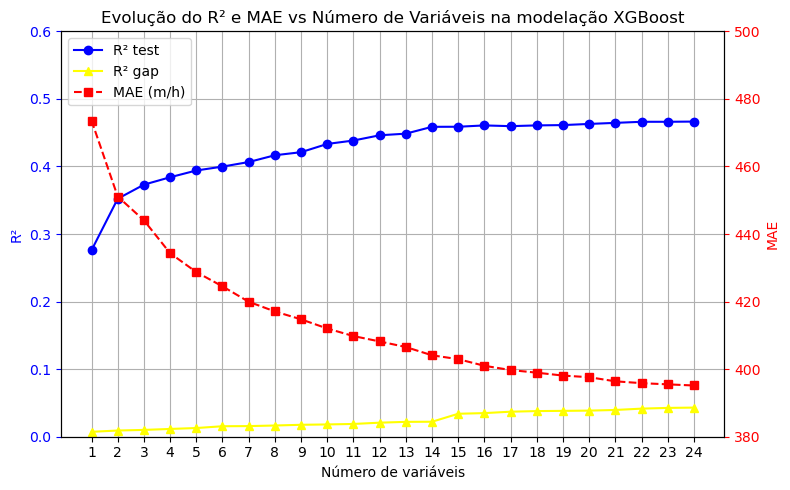

In [66]:
import matplotlib.pyplot as plt
import numpy as np

num_vars = range(1, 25)

# Extrair métricas do dicionário
r2_test_scores_plot = [metrics_dict[i]['r2_test_mean'] for i in num_vars]
r2_gap_scores_plot  = [metrics_dict[i]['r2_gap_mean'] for i in num_vars]
mae_linear_scores_plot = [metrics_dict[i]['mae_lin_mean'] for i in num_vars]

fig, ax1 = plt.subplots(figsize=(8, 5))

# Eixo primário (R²)
ax1.plot(num_vars, r2_test_scores_plot, marker='o', label='R² test', color='blue')
ax1.plot(num_vars, r2_gap_scores_plot, marker='^', color='yellow', label='R² gap')  # linha do gap
ax1.set_xlabel('Número de variáveis')
ax1.set_xticks(list(num_vars))
ax1.set_ylim(0, 0.6)
ax1.set_ylabel('R²', color='blue')
ax1.tick_params(axis='y', colors='blue')
ax1.set_title('Evolução do R² e MAE vs Número de Variáveis na modelação XGBoost')
ax1.grid(True, which='both', axis='both')

# Eixo secundário (MAE)
ax2 = ax1.twinx()
ax2.plot(num_vars, mae_linear_scores_plot, marker='s', linestyle='--', color='red', label='MAE (m/h)')

# Definir os dois pontos de mapeamento
r2_point1, mae_point1 = 0.1, 400
r2_point2, mae_point2 = 0.6, 500

# Coeficientes da função linear y2 = a*y1 + b
a = (mae_point2 - mae_point1) / (r2_point2 - r2_point1)
b = mae_point1 - a * r2_point1

# Obter os limites atuais de R² para calcular y2 correspondente
y1_min, y1_max = ax1.get_ylim()
y2_min = a * y1_min + b
y2_max = a * y1_max + b

# Definir limite e ticks do eixo secundário
ax2.set_ylim(y2_min, y2_max)

# Criar ticks de 20 em 20 para y2
mae_ticks = np.arange(380, 501, 20)
ax2.set_yticks(mae_ticks)

ax2.set_ylabel('MAE', color='red')
ax2.tick_params(axis='y', colors='red')
ax2.set_xlim(ax1.get_xlim())

# Adicionar legendas combinadas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()


In [67]:
# ============================
# Top N features do FFS
# ============================
n_features = 14
final_selected_features = selected_features[:n_features]

print(f"Selected features ({n_features}):")
print(final_selected_features)

# ============================
# Pré-processamento apenas para as features selecionadas
# ============================
numeric_cols_sel = X[final_selected_features].select_dtypes(include=['number']).columns.tolist()
categorical_cols_sel = X[final_selected_features].select_dtypes(include=['category']).columns.tolist()

preprocessor_sel = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # remove NaNs
        ('scaler', StandardScaler())
    ]), numeric_cols_sel),
    ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols_sel)
])

# ============================
# Pipeline final Ridge
# ============================
final_pipeline = Pipeline([
    ('preprocessor', preprocessor_sel),
    ('regressor', Ridge(alpha=1.0))  # ou o alpha que você escolheu
])

# Treinar modelo final
final_pipeline.fit(X[final_selected_features], y)

# ============================
# Salvar pipeline final
# ============================
model_path = "../../Data/Models/model_linear.pkl"
with open(model_path, "wb") as f:
    pickle.dump(final_pipeline, f)

print(f"\nModelo final com Ridge salvo em {model_path}")


Selected features (14):
['duration_p_log', 'HDW_av', 'wSv_1_av', 'sP_hPa_av', 'wco_500_av', '8_ny_fir_p_log', 't_700_av', '3_8y_fir_p_log', 'f_load_av_log', 'VPD_Pa_av_log', 'wco_700_av', 'DC_12h_av_log', 'wv_300_av_log', 'f_start_log']

Modelo final com Ridge salvo em ../../Data/Models/model_linear.pkl


In [68]:
m = metrics_dict[n_features]

print(f"=== Desempenho final ({n_features} features) ===")
print(f"R² treino: {m['r2_train_mean']:.4f} ± {m['r2_train_std']:.4f}")
print(f"R² teste : {m['r2_test_mean']:.4f} ± {m['r2_test_std']:.4f}")
print(f"R² gap   : {m['r2_gap_mean']:.4f} ± {m['r2_gap_std']:.4f}\n")

print("=== LOG ===")
print(f"MAE  : {m['mae_log_mean']:.4f} m/h ± {m['mae_log_std']:.4f} m/h")
print(f"RMSE : {m['rmse_log_mean']:.4f} m/h ± {m['rmse_log_std']:.4f} m/h\n")

print("=== LINEAR ===")
print(f"MAE  : {m['mae_lin_mean']:.2f} m/h ± {m['mae_lin_std']:.2f} m/h")
print(f"RMSE : {m['rmse_lin_mean']:.2f} m/h ± {m['rmse_lin_std']:.2f} m/h")


=== Desempenho final (14 features) ===
R² treino: 0.4809 ± 0.0124
R² teste : 0.4587 ± 0.0534
R² gap   : 0.0222 ± 0.0657

=== LOG ===
MAE  : 0.5933 m/h ± 0.0270 m/h
RMSE : 0.7652 m/h ± 0.0390 m/h

=== LINEAR ===
MAE  : 404.10 m/h ± 29.56 m/h
RMSE : 699.96 m/h ± 91.89 m/h


In [69]:
# Obter os nomes das colunas após o preprocessor
feature_names = []

# Numéricas
if numeric_cols_sel:
    feature_names += numeric_cols_sel

# One-hot codificadas
if categorical_cols_sel:
    ohe = final_pipeline.named_steps['preprocessor'].named_transformers_['cat']
    ohe_names = ohe.get_feature_names_out(categorical_cols_sel).tolist()
    feature_names += ohe_names

# Coeficientes
ridge_model = final_pipeline.named_steps['regressor']
coefs = ridge_model.coef_
intercept = ridge_model.intercept_

print("\n=== Equação da regressão Ridge ===")
equation_terms = [f"{coef:.4f}*{name}" for coef, name in zip(coefs, feature_names)]
equation = " + ".join(equation_terms)
equation = f"y = {intercept:.4f} + " + equation
print(equation)



=== Equação da regressão Ridge ===
y = 6.2086 + -0.4225*duration_p_log + 0.2383*HDW_av + 0.2578*wSv_1_av + -0.1044*sP_hPa_av + -0.3102*wco_500_av + 0.0798*8_ny_fir_p_log + -0.1230*t_700_av + 0.1470*3_8y_fir_p_log + 0.0728*f_load_av_log + 0.1774*VPD_Pa_av_log + 0.1775*wco_700_av + 0.1148*DC_12h_av_log + -0.0732*wv_300_av_log + -0.1135*f_start_log


In [70]:
# =============================
# SHAP + Predições médias + Merge com GeoDataFrame
# =============================

avg_pred_log = pred_log_dict[n_features]           # predição log CV-safe
avg_pred_linear = inverse_safe_log(avg_pred_log)   # predição linear
avg_actual_log = y.values                           # valores reais log
avg_actual_linear = inverse_safe_log(y.values).round(6)     # valores reais linear

# -----------------------------
# Carregar shapefile e selecionar apenas observações do df
# -----------------------------
gdf = gpd.read_file(shp_path).reset_index(drop=True)
gdf_valid = gdf.loc[df.index].reset_index(drop=True)

# -----------------------------
# Criar DataFrame de resultados
# -----------------------------
shap_results = pd.DataFrame({
    'ros_p_log': avg_actual_log,
    'ros_p_linear': avg_actual_linear,
    'PredROS_log': avg_pred_log,
    'PredROS_linear': avg_pred_linear,
})

# Erros e flags
shap_results['PredDiff'] = shap_results['PredROS_linear'] - shap_results['ros_p_linear']
shap_results['Err_pct'] = (shap_results['PredDiff'] / shap_results['ros_p_linear']) * 100
shap_results['Error_p_abs'] = shap_results['Err_pct'].abs()
shap_results['bad_pred'] = shap_results['Error_p_abs'] > 35

In [71]:
import shap
# -----------------------------
# SHAP values para o modelo final
# -----------------------------

# nomes das features após o preprocessor (inclui one-hot)
feature_names_transformed = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_names_transformed = [name.split('__')[-1] for name in feature_names_transformed]


# Explainer
explainer = shap.LinearExplainer(
    final_pipeline.named_steps['regressor'], 
    preprocessor_sel.transform(X[final_selected_features]), 
    feature_perturbation="interventional"
)

# valores SHAP
shap_values = explainer.shap_values(preprocessor_sel.transform(X[final_selected_features]))

# DataFrame com nomes corretos
shap_values_df = pd.DataFrame(
    shap_values,
    columns=feature_names_transformed,
    index=X.index
)

# adicionar prefixo para evitar colisões
shap_values_df = shap_values_df.add_prefix("shap_")

# -----------------------------
# Merge com GeoDataFrame
# -----------------------------
shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_short.shp'
gdf_final = gpd.read_file(shp_path)

merged_gdf = gpd.GeoDataFrame(
    pd.concat([
        gdf_final.reset_index(drop=True),
        df_log[log_features].reset_index(drop=True),
        shap_results.reset_index(drop=True),
        shap_values_df.reset_index(drop=True)
    ], axis=1),
    geometry='geometry',
    crs=gdf_final.crs
)


In [72]:
print(feature_names_transformed)

['duration_p_log', 'HDW_av', 'wSv_1_av', 'sP_hPa_av', 'wco_500_av', '8_ny_fir_p_log', 't_700_av', '3_8y_fir_p_log', 'f_load_av_log', 'VPD_Pa_av_log', 'wco_700_av', 'DC_12h_av_log', 'wv_300_av_log', 'f_start_log']


In [73]:
# -----------------------------
# Export
# -----------------------------
output_base = "../../Data/Models/PT_FireProg_model_SHAP_linear"

merged_gdf.to_file(f"{output_base}.shp")
merged_gdf.drop(columns='geometry').to_csv(f"{output_base}.csv", index=False)

print("✓ SHP e CSV exportados com sucesso")

✓ SHP e CSV exportados com sucesso


## PLOTS

In [74]:
# Extrair métricas do dicionário
metrics = metrics_dict[n_features]

r2_train_cv = metrics["r2_train_mean"]
r2_train_std = metrics["r2_train_std"]
r2_test_cv = metrics["r2_test_mean"]
r2_test_std = metrics["r2_test_std"]
r2_gap_cv = metrics["r2_gap_mean"]
r2_gap_std = metrics["r2_gap_std"]

mae_cv_mean = metrics["mae_log_mean"]
mae_cv_std = metrics["mae_log_std"]
rmse_cv_mean = metrics["rmse_log_mean"]
rmse_cv_std = metrics["rmse_log_std"]

mae_linear_mean = metrics["mae_lin_mean"]
mae_linear_std = metrics["mae_lin_std"]
rmse_linear_mean = metrics["rmse_lin_mean"]
rmse_linear_std = metrics["rmse_lin_std"]

# Predições log CV-safe para n_features
y_pred_all = pred_log_dict[n_features]
y_actual_all = y

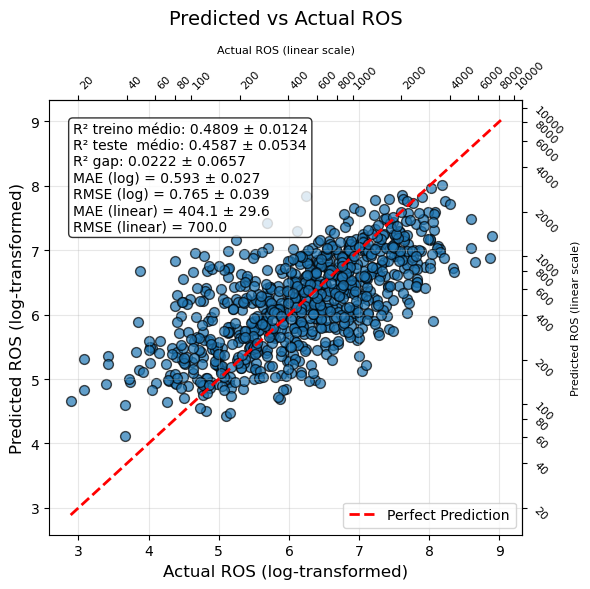

In [75]:
# =============================
# Scatter Plot com ± std
# =============================
fig, ax = plt.subplots(figsize=(6, 6))
sc = ax.scatter(y_actual_all, y_pred_all, alpha=0.7, edgecolor='k', s=50)

min_val = min(y_actual_all.min(), y_pred_all.min() - 1)
max_val = max(y_actual_all.max(), y_pred_all.max() + 1)
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_title('Predicted vs Actual ROS', fontsize=14, pad=15)
ax.set_xlabel('Actual ROS (log-transformed)', fontsize=12)
ax.set_ylabel('Predicted ROS (log-transformed)', fontsize=12)

ax.text(
    0.05, 0.95,
    f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}\n"
    f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}\n"
    f"R² gap: {r2_gap_cv:.4f} ± {r2_gap_std:.4f}\n"
    f'MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f}\n'
    f'RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f}\n'
    f'MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}\n'
    f'RMSE (linear) = {rmse_linear_mean:.1f}',
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# =============================
# Eixos secundários (linear scale)
# =============================
def log_to_linear(x):
    return np.exp(x)

def linear_to_log(x):
    # Evita log(0)
    x_safe = np.where(x <= 0, 1e-6, x)
    return np.log(x_safe)

# Eixo superior (x) e direito (y)
ax_top = ax.secondary_xaxis('top', functions=(log_to_linear, linear_to_log))
ax_right = ax.secondary_yaxis('right', functions=(log_to_linear, linear_to_log))

# Ticks escalonados conforme seu exemplo
ticks_linear = list(range(0, 101, 20))        # 0,20,40,60,80,100
ticks_linear += list(range(200, 1001, 200))   # 200,400,...,1000
ticks_linear += list(range(2000, 10001, 2000))# 2000,4000,...,10000

ax_top.set_xticks(ticks_linear)
ax_right.set_yticks(ticks_linear)
plt.setp(ax_right.get_yticklabels(), rotation=315, ha='left', fontsize=8)
plt.setp(ax_top.get_xticklabels(), rotation=45, ha='left', fontsize=8)

ax_top.set_xlabel("Actual ROS (linear scale)", fontsize=8)
ax_right.set_ylabel("Predicted ROS (linear scale)", fontsize=8)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

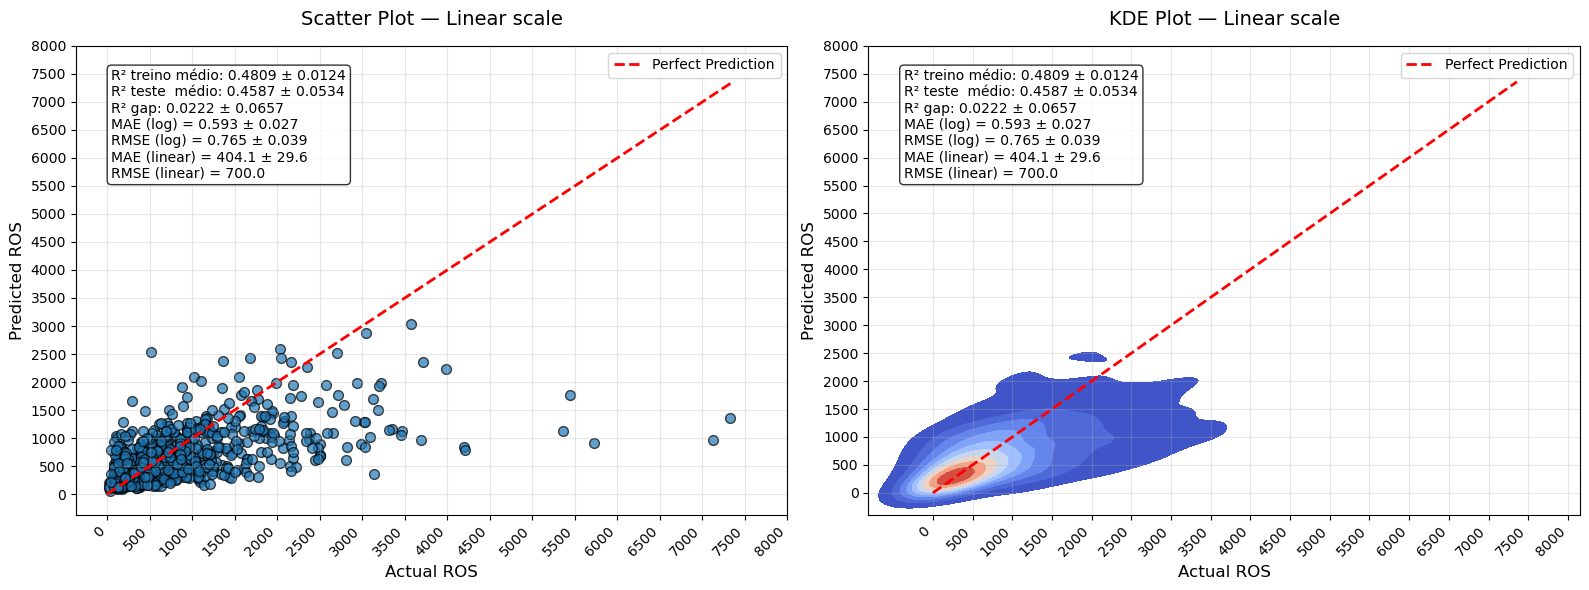

In [76]:
# =============================
# Scatter + 2D KDE com estilo parecido + caixa de texto
# =============================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# -----------------------------
# Scatter plot (ax1)
# -----------------------------
sc1 = ax1.scatter(
    avg_actual_linear, avg_pred_linear,
    alpha=0.7, edgecolor='k', s=50
)

max_val = max(avg_actual_linear.max(), avg_pred_linear.max()) * 1.005
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax1.set_title("Scatter Plot — Linear scale", fontsize=14, pad=15)
ax1.set_xlabel("Actual ROS", fontsize=12)
ax1.set_ylabel("Predicted ROS", fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# -----------------------------
# Caixa de texto (ax1)
# -----------------------------
ax1.text(
    0.05, 0.95,
    f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}\n"
    f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}\n"
    f"R² gap: {r2_gap_cv:.4f} ± {r2_gap_std:.4f}\n"
    f'MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f}\n'
    f'RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f}\n'
    f'MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}\n'
    f'RMSE (linear) = {rmse_linear_mean:.1f}',
    transform=ax1.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# 2D KDE plot (ax2)
# -----------------------------
sns.kdeplot(
    x=avg_actual_linear,
    y=avg_pred_linear,
    fill=True,
    cmap="coolwarm",
    thresh=0.04,
    ax=ax2
)
ax2.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_title("KDE Plot — Linear scale", fontsize=14, pad=15)
ax2.set_xlabel("Actual ROS", fontsize=12)
ax2.set_ylabel("Predicted ROS", fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

# -----------------------------
# Caixa de texto (ax2)
# -----------------------------
ax2.text(
    0.05, 0.95,
    f"R² treino médio: {r2_train_cv:.4f} ± {r2_train_std:.4f}\n"
    f"R² teste  médio: {r2_test_cv:.4f} ± {r2_test_std:.4f}\n"
    f"R² gap: {r2_gap_cv:.4f} ± {r2_gap_std:.4f}\n"
    f'MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f}\n'
    f'RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f}\n'
    f'MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}\n'
    f'RMSE (linear) = {rmse_linear_mean:.1f}',
    transform=ax2.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# Ticks escalonados e layout
# -----------------------------
ticks = list(range(0, 8001, 500))
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=10)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=10)
plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


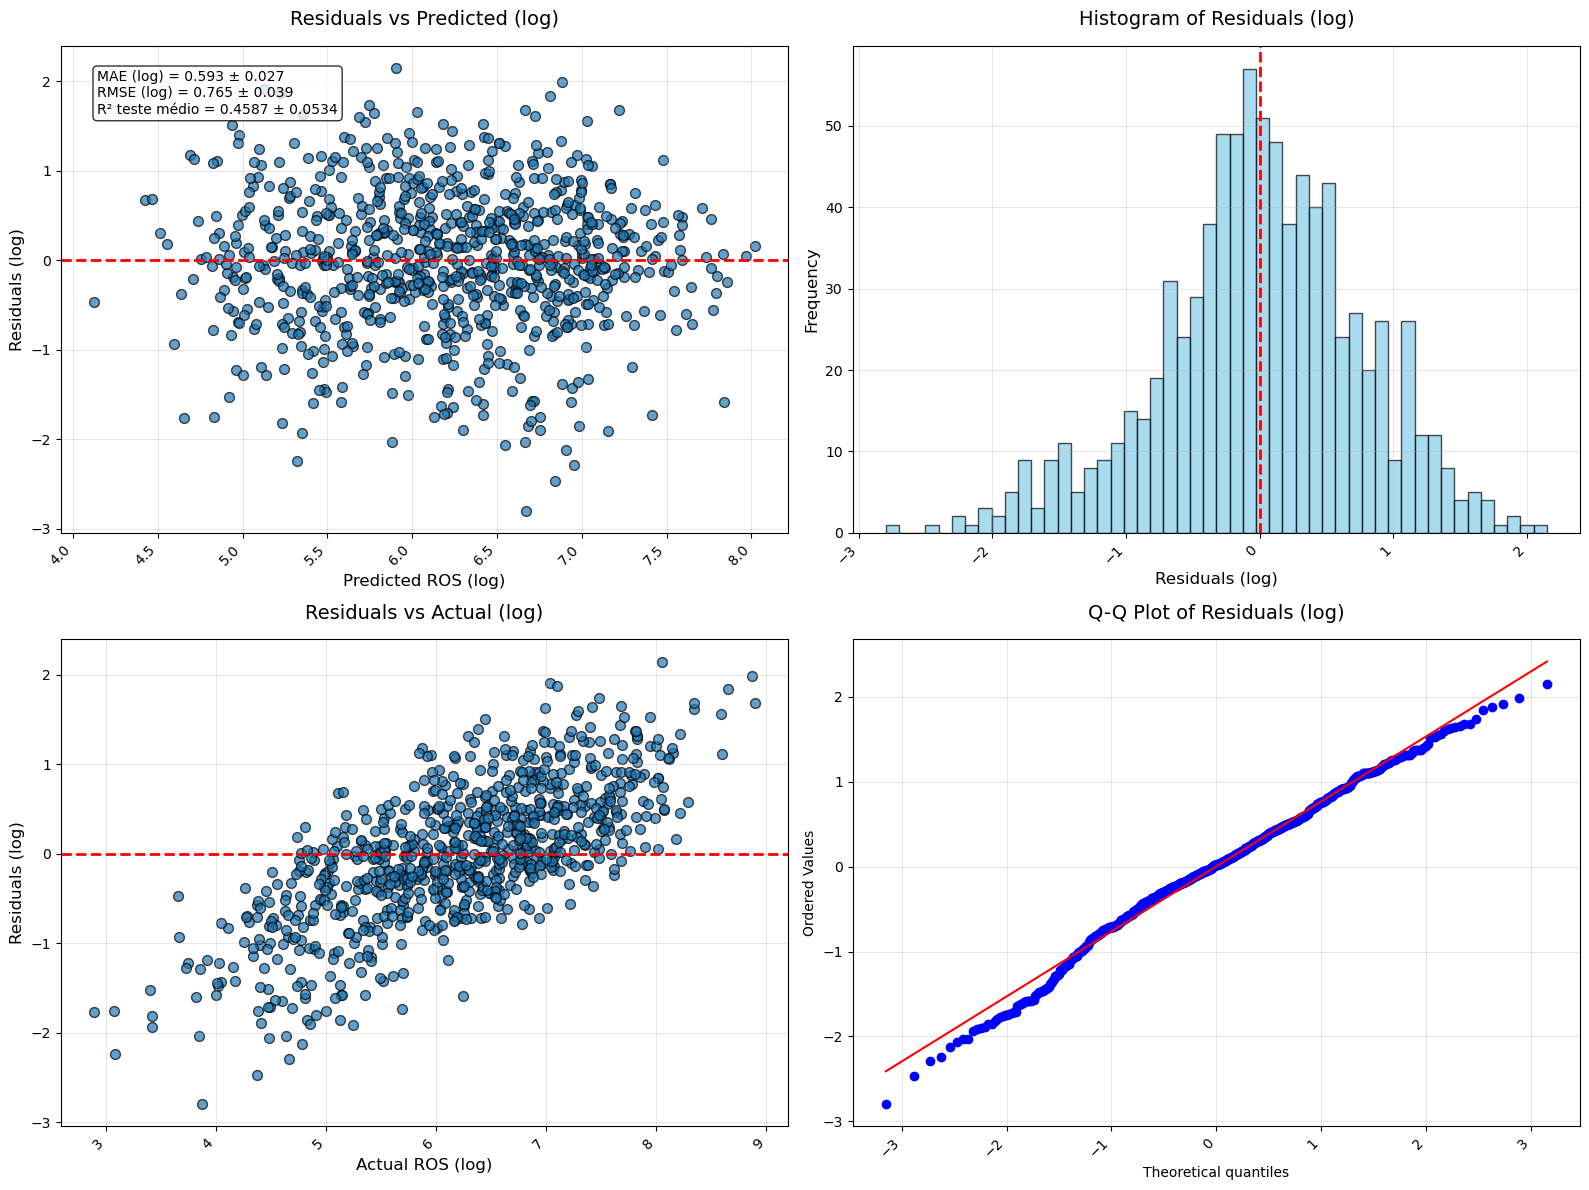

In [77]:
residuals_log = avg_actual_log - avg_pred_log

fig, axes = plt.subplots(2, 2, figsize=(16,12))

# -----------------------------
# Scatter: Residuals vs Predicted (log)
# -----------------------------
ax = axes[0,0]
sc = ax.scatter(avg_pred_log, residuals_log, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Predicted (log)", fontsize=14, pad=15)
ax.set_xlabel("Predicted ROS (log)", fontsize=12)
ax.set_ylabel("Residuals (log)", fontsize=12)
ax.grid(True, alpha=0.3)

# Caixa de texto com métricas
ax.text(
    0.05, 0.95,
    f"MAE (log) = {mae_cv_mean:.3f} ± {mae_cv_std:.3f}\n"
    f"RMSE (log) = {rmse_cv_mean:.3f} ± {rmse_cv_std:.3f}\n"
    f"R² teste médio = {r2_test_cv:.4f} ± {r2_test_std:.4f}",
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# Histogram of Residuals
# -----------------------------
ax = axes[0,1]
ax.hist(residuals_log, bins=50, color='skyblue', edgecolor='k', alpha=0.7)
ax.axvline(0, color='r', ls='--', linewidth=2)
ax.set_title("Histogram of Residuals (log)", fontsize=14, pad=15)
ax.set_xlabel("Residuals (log)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Scatter: Residuals vs Actual (log)
# -----------------------------
ax = axes[1,0]
sc = ax.scatter(avg_actual_log, residuals_log, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Actual (log)", fontsize=14, pad=15)
ax.set_xlabel("Actual ROS (log)", fontsize=12)
ax.set_ylabel("Residuals (log)", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Q-Q Plot
# -----------------------------
ax = axes[1,1]
stats.probplot(residuals_log, dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Residuals (log)", fontsize=14, pad=15)
ax.grid(True, alpha=0.3)

# -----------------------------
# Ticks e layout
# -----------------------------
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


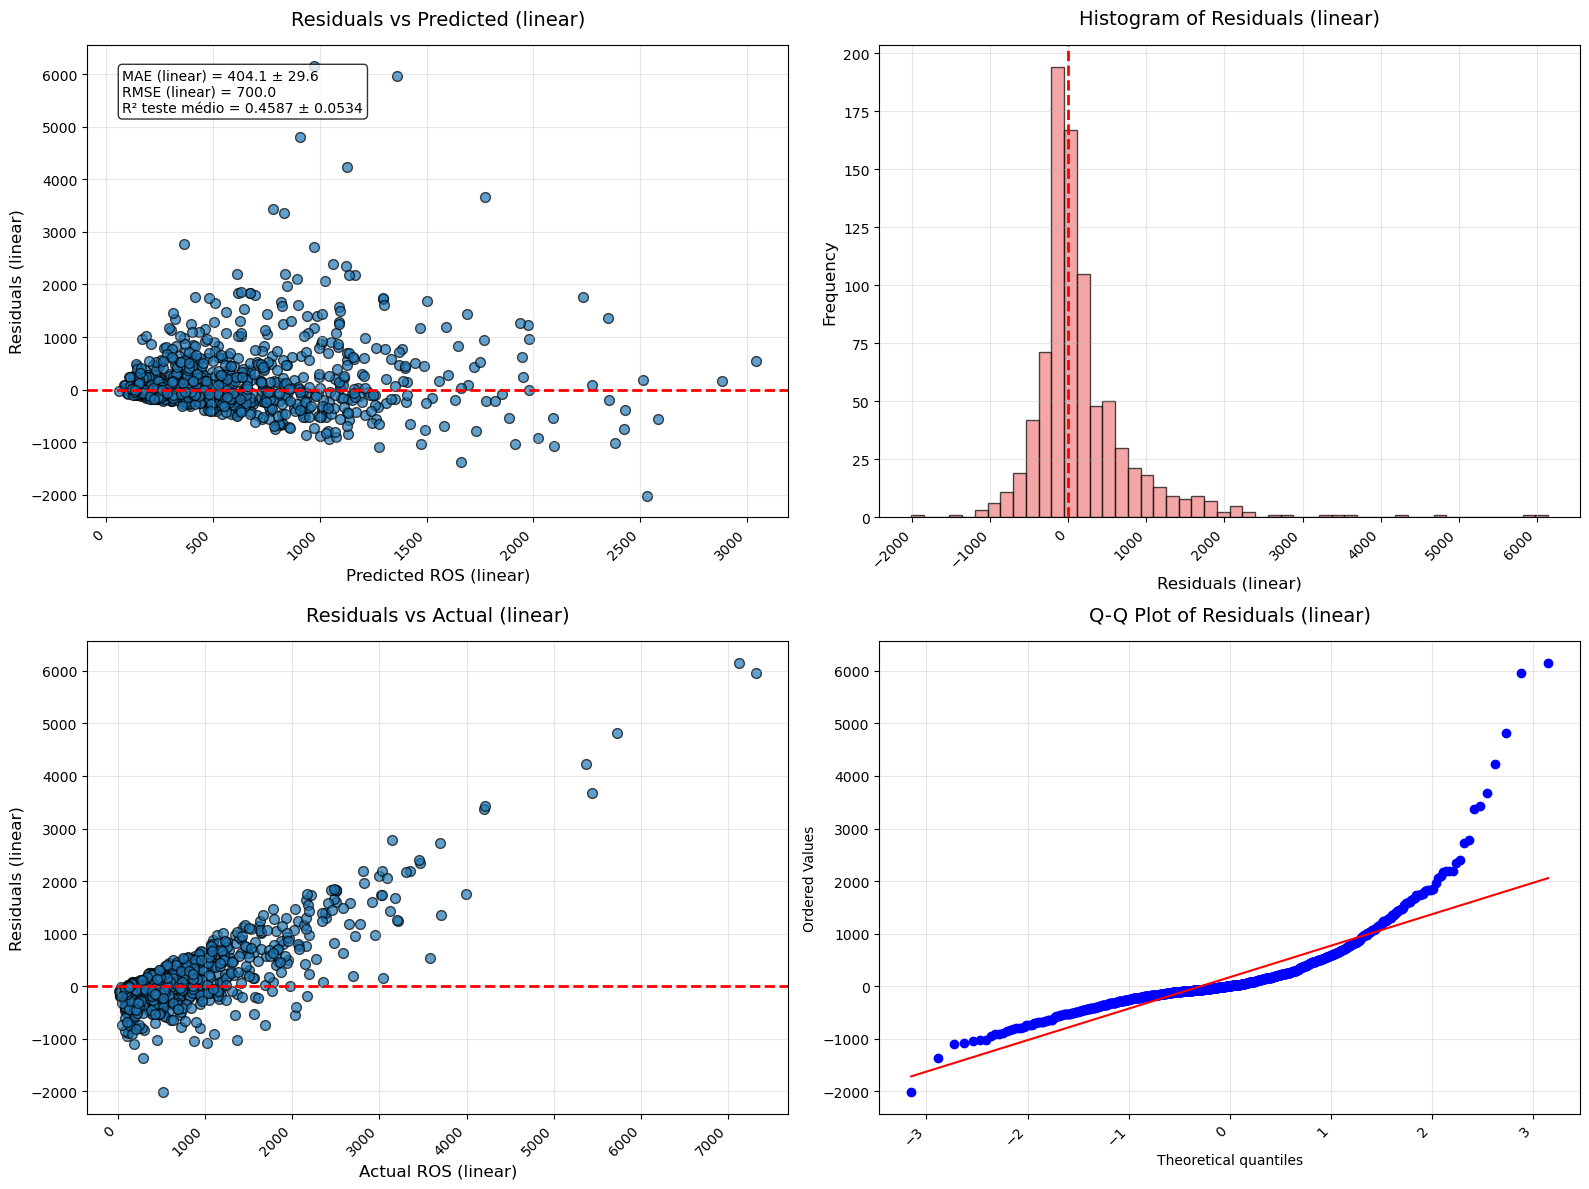

In [78]:
residuals_linear = avg_actual_linear - avg_pred_linear

fig, axes = plt.subplots(2, 2, figsize=(16,12))

# -----------------------------
# Scatter: Residuals vs Predicted (linear)
# -----------------------------
ax = axes[0,0]
sc = ax.scatter(avg_pred_linear, residuals_linear, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Predicted (linear)", fontsize=14, pad=15)
ax.set_xlabel("Predicted ROS (linear)", fontsize=12)
ax.set_ylabel("Residuals (linear)", fontsize=12)
ax.grid(True, alpha=0.3)

# Caixa de texto com métricas
ax.text(
    0.05, 0.95,
    f"MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}\n"
    f"RMSE (linear) = {rmse_linear_mean:.1f}\n"
    f"R² teste médio = {r2_test_cv:.4f} ± {r2_test_std:.4f}",
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# Histogram of Residuals
# -----------------------------
ax = axes[0,1]
ax.hist(residuals_linear, bins=50, color='lightcoral', edgecolor='k', alpha=0.7)
ax.axvline(0, color='r', ls='--', linewidth=2)
ax.set_title("Histogram of Residuals (linear)", fontsize=14, pad=15)
ax.set_xlabel("Residuals (linear)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Scatter: Residuals vs Actual (linear)
# -----------------------------
ax = axes[1,0]
sc = ax.scatter(avg_actual_linear, residuals_linear, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Actual (linear)", fontsize=14, pad=15)
ax.set_xlabel("Actual ROS (linear)", fontsize=12)
ax.set_ylabel("Residuals (linear)", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Q-Q Plot
# -----------------------------
ax = axes[1,1]
stats.probplot(residuals_linear, dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Residuals (linear)", fontsize=14, pad=15)
ax.grid(True, alpha=0.3)

# -----------------------------
# Ticks e layout
# -----------------------------
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()


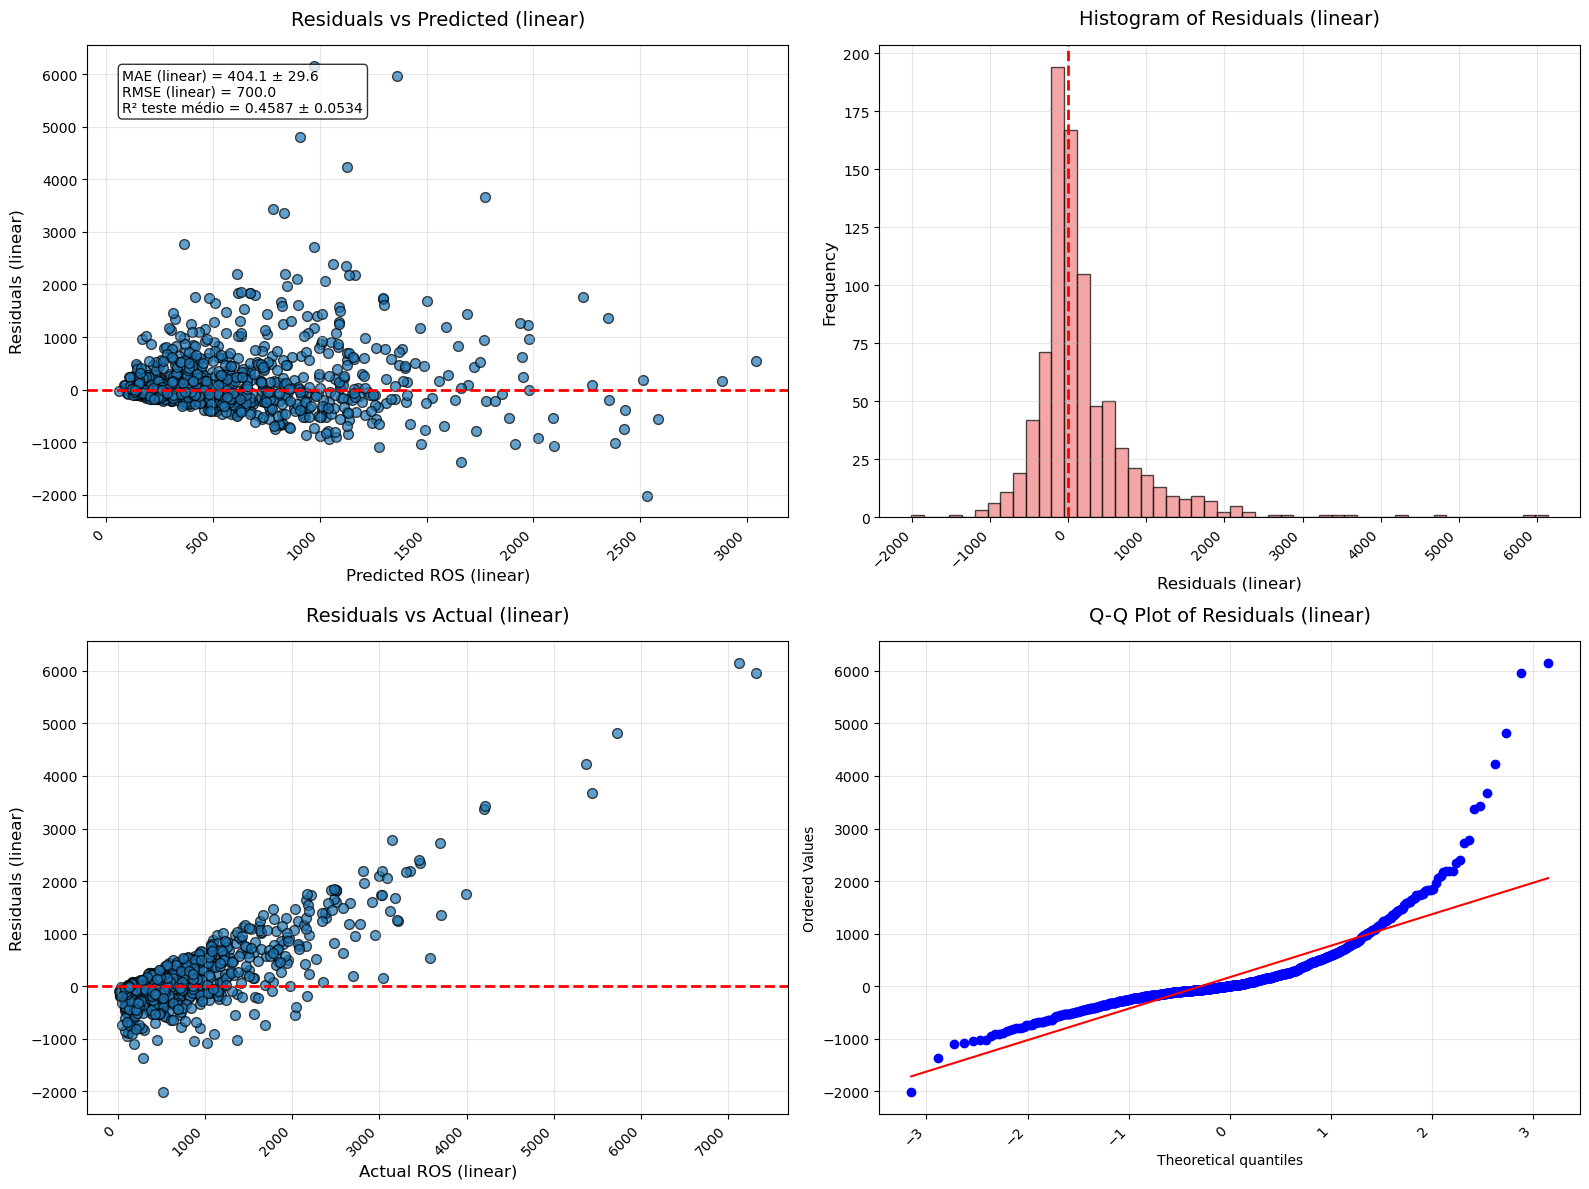

In [79]:
residuals_linear = avg_actual_linear - avg_pred_linear

fig, axes = plt.subplots(2, 2, figsize=(16,12))

# -----------------------------
# Scatter: Residuals vs Predicted (linear)
# -----------------------------
ax = axes[0,0]
sc = ax.scatter(avg_pred_linear, residuals_linear, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Predicted (linear)", fontsize=14, pad=15)
ax.set_xlabel("Predicted ROS (linear)", fontsize=12)
ax.set_ylabel("Residuals (linear)", fontsize=12)
ax.grid(True, alpha=0.3)

# Caixa de texto com métricas
ax.text(
    0.05, 0.95,
    f"MAE (linear) = {mae_linear_mean:.1f} ± {mae_linear_std:.1f}\n"
    f"RMSE (linear) = {rmse_linear_mean:.1f}\n"
    f"R² teste médio = {r2_test_cv:.4f} ± {r2_test_std:.4f}",
    transform=ax.transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# -----------------------------
# Histogram of Residuals
# -----------------------------
ax = axes[0,1]
ax.hist(residuals_linear, bins=50, color='lightcoral', edgecolor='k', alpha=0.7)
ax.axvline(0, color='r', ls='--', linewidth=2)
ax.set_title("Histogram of Residuals (linear)", fontsize=14, pad=15)
ax.set_xlabel("Residuals (linear)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Scatter: Residuals vs Actual (linear)
# -----------------------------
ax = axes[1,0]
sc = ax.scatter(avg_actual_linear, residuals_linear, alpha=0.7, edgecolor='k', s=50)
ax.axhline(0, color='r', ls='--', linewidth=2)
ax.set_title("Residuals vs Actual (linear)", fontsize=14, pad=15)
ax.set_xlabel("Actual ROS (linear)", fontsize=12)
ax.set_ylabel("Residuals (linear)", fontsize=12)
ax.grid(True, alpha=0.3)

# -----------------------------
# Q-Q Plot
# -----------------------------
ax = axes[1,1]
stats.probplot(residuals_linear, dist="norm", plot=ax)
ax.set_title("Q-Q Plot of Residuals (linear)", fontsize=14, pad=15)
ax.grid(True, alpha=0.3)

# -----------------------------
# Ticks e layout
# -----------------------------
for ax in axes.flatten():
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()
